In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
from copy import copy
import matplotlib.pyplot as plt
import torch

import sys
sys.path.append('..')
from instances.BoxQP_instances.BoxQP_instances import *
from src.instance import BoxQP
import src.optimizers as cim_opt
from scripts.utils import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 32
stride = 1

# Get instance data and construct BoxQP object

In [3]:
instance_name = 'spar125-075-1'
inst, label = get_BoxQP_instance(instance_name)
Q, V, GT_obj = inst
boxqp = BoxQP(Q, V, device=device)
N = Q.shape[0]

## Generate SDE params and use prep_params to convert keywords to functions


In [4]:
SDE_params = {
    'pump_schedule' : 'linear',
    'j_schedule' : 'constant',
    'initial_p' : 0.0,
    'final_p' : 2.5,
    'dt' : 0.0025,
    'N' : 2,
    'T' : 15000,
    'j': 1,
    'g': 0.01,
    'lam': 25,
    'rescale_prob' : True, 
    'clamp' : False
}
SDE_params = prep_params(SDE_params, 'MF')

Setting linear pump for MF
Setting constant j for MF


## Generate optimizer params and construct optimizer

In [5]:
OPT_params = {
    'method': 'SGD',
    'lr': 1.0,
    'momentum': 0.9
}

if OPT_params['method'] == 'SGD':
    opt = cim_opt.SGD(torch.zeros((batch_size, N)).to(device), **OPT_params)
elif OPT_params['method'] == 'Adam':
    opt = cim_opt.Adam(torch.zeros((batch_size, N)).to(device), **OPT_params)
else:
    print('Optimizer not implemented')

## Construct SDE, simulate, and parse to results

In [6]:
sde = MF(F=boxqp, opt=opt, **SDE_params)
ts = (torch.arange(0, SDE_params['T']) * SDE_params['dt']).to(device)
ys, runtime = sde.simulate(ts, batch_size, stride=stride, device=device)
res = result(ys, sde.F, runtime, running_min=False)
bounds = copy(sde.F.bounds())

Final p = 2.5, final j = 1
Rescaling problem instance to (-70.71067811865476, 70.71067811865476)


SDE Batch 1 out of 1: 100%|██████████| 14999/14999 [00:04<00:00, 3243.99it/s]


## Plot relative optimality gaps versus roundtrips/iterations

Text(0, 0.5, 'Relative Error')

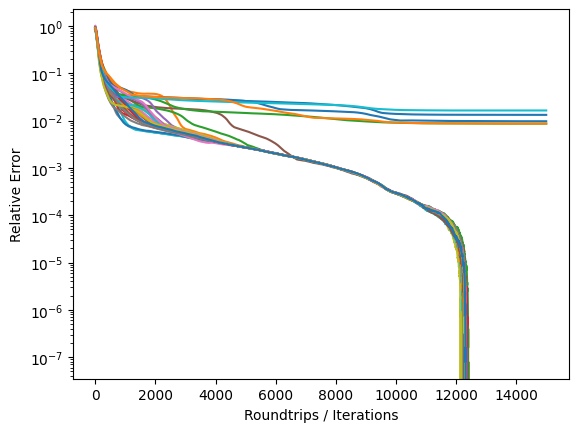

In [10]:
plt.plot(stride * np.arange(res.energies.shape[0]), (res.energies - GT_obj) / np.abs(GT_obj))
ax = plt.gca()
ax.set_yscale('log')
ax.set_xlabel('Roundtrips / Iterations')
ax.set_ylabel('Relative Error')

## Plot OPO values, double-well values, and transformed optimization variables for the first sample

Text(0, 0.5, 'Optimization variables')

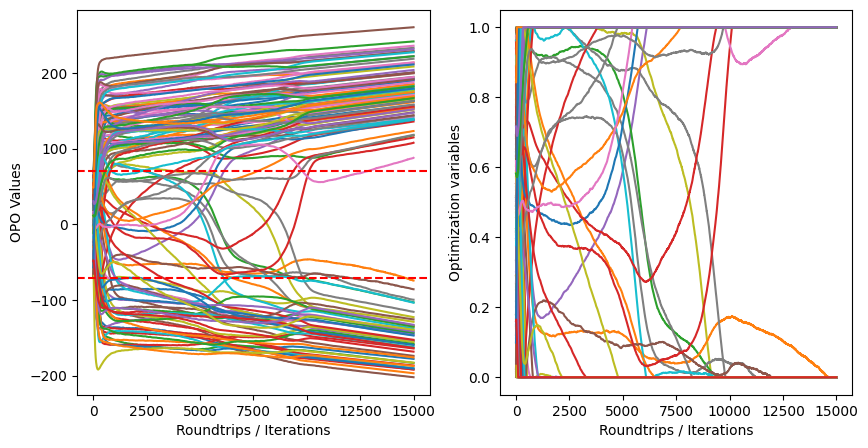

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(stride * np.arange(ys.shape[0]), ys[:, 0, :N].cpu().numpy())
axs[0].axhline(bounds[0], color='r', linestyle='--')
axs[0].axhline(bounds[1], color='r', linestyle='--')
axs[0].set_xlabel('Roundtrips / Iterations')
axs[0].set_ylabel('OPO Values')

axs[1].plot(stride * np.arange(ys.shape[0]), res.ys[:, 0, :N].cpu().numpy())
axs[1].set_xlabel('Roundtrips / Iterations')
axs[1].set_ylabel('Optimization variables')